<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

In [1]:
import pandas as pd

import re

import nltk
from nltk.corpus import stopwords as nltk_stopwords

import spacy
nlp = spacy.load('en_core_web_sm')

from pymystem3 import Mystem

from tqdm.notebook import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split, RandomizedSearchCV

from sklearn.metrics import f1_score 

from sklearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeClassifier

from lightgbm import LGBMRegressor

from catboost import CatBoostClassifier



## Подготовка

In [2]:
#считаем данные и загрузим в датафрейм
toxic_data = pd.read_csv('toxic_comments.csv', index_col=0)

In [3]:
# выведем общее инфо
toxic_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


В данных нет пропусков, типы данных соответствуют ожидаемым

In [4]:
toxic_data.head(10)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


In [5]:
#создадим функцию для лемматизации и очистки текста
def lemmatize(text):
    cleaned_text = []
    document = list(nlp.pipe(text, batch_size=20000))
    for doc in document:
        sent = [
            str(token.lemma_).lower()
            for token in doc
            if not token.is_punct
            and not token.is_stop
            and not token.like_num
            and token.is_alpha
        ]
        cleaned_text.append(" ".join(sent))
    return cleaned_text

In [6]:
#создадим тестовый датафрейм для проверки работы лемматизатора
sentence1 = "The striped bats are hanging on their feet for best"
sentence2 = "you should be ashamed of yourself went worked"
df_my = pd.DataFrame([sentence1, sentence2], columns = ['text'])
print(df_my)

                                                text
0  The striped bats are hanging on their feet for...
1      you should be ashamed of yourself went worked


In [7]:
print(df_my.apply(lambda x: lemmatize(x[['text']]), axis=1).map(' '.join))

0    stripe bat hang foot good
1              ashamed go work
dtype: object


Проверили, что лемматизатор работает верно, применим функцию ко всему датасету

In [8]:
tqdm.pandas(desc="Processing")

#примененим функцию к тексту
toxic_data['lemm_text'] = toxic_data.progress_apply(lambda x: lemmatize(x[['text']]), axis=1).map(' '.join)

Processing:   0%|          | 0/159292 [00:00<?, ?it/s]

In [9]:
toxic_data.head()

,text,toxic,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,explanation edit username hardcore metallica f...
1,D'aww! He matches this background colour I'm s...,0,match background colour seemingly stuck thank ...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man try edit war guy constantly remove rel...
3,"""\nMore\nI can't make any real suggestions on ...",0,real suggestion improvement wonder section sta...
4,"You, sir, are my hero. Any chance you remember...",0,sir hero chance remember page


<AxesSubplot:>

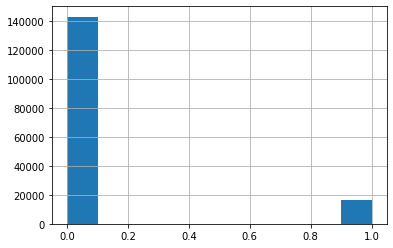

In [10]:
#посмотрим на баланс классов целевого признака в выборке
toxic_data['toxic'].hist()

Видим, что есть сильный дисбаланс классов - будем использовать инструменты для балансирования при обучении моделей

In [11]:
#скопируем датасет
df = toxic_data.copy()

In [12]:
RANDOM_STATE=42

#выделяем в отдельные переменные целевой признак и входные признаки
y = df['toxic']
X = df.drop(['toxic', 'text'], axis = 1)

In [13]:
#разделим выборку на тестовую и тренировочную   
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y)

### Вывод
Загрузили и подготовили данные. Был отмечен сильный дисбаланс классов в целевом признаке. Провели лемматизацию и очистку текста. Рассчитали величины TF-IDF для создания признаков для обучения моделей

## Обучение

In [18]:
#создаём итоговый пайплайн
pipe_final = Pipeline([
    ('vect', ColumnTransformer([
            ('tfidf', TfidfVectorizer(), 'lemm_text')
        ], remainder='drop' 
        )),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [19]:
param_grid = [
    #словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced')],
        'models__max_depth': range(3, 9),
        'models__min_samples_leaf': range(2, 7) 
    },

    #словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            #penalty='l2',
            max_iter=3000,
            class_weight='balanced'
        )],
        'models__C': [5, 10, 15],
        'models__penalty': ['l1', 'l2']
    },
    
     #словарь для модели CatBoostClassifier()
    {
        'models': [CatBoostClassifier(random_state=RANDOM_STATE, auto_class_weights='Balanced')],
        'models__depth': [4, 6],
        'models__iterations': [10, 50]
    }
]

In [20]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=3,
    scoring='f1',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    n_iter=30
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Learning rate set to 0.5
0:	learn: 0.5919656	total: 819ms	remaining: 40.1s
1:	learn: 0.5374784	total: 1.45s	remaining: 34.9s
2:	learn: 0.5111842	total: 2.08s	remaining: 32.6s
3:	learn: 0.4920022	total: 2.73s	remaining: 31.4s
4:	learn: 0.4805025	total: 3.34s	remaining: 30s
5:	learn: 0.4691201	total: 3.95s	remaining: 28.9s
6:	learn: 0.4563681	total: 4.56s	remaining: 28s
7:	learn: 0.4484333	total: 5.16s	remaining: 27.1s
8:	learn: 0.4362912	total: 5.76s	remaining: 26.3s
9:	learn: 0.4316181	total: 6.38s	remaining: 25.5s
10:	learn: 0.4261078	total: 6.98s	remaining: 24.8s
11:	learn: 0.4204315	total: 7.6s	remaining: 24.1s
12:	learn: 0.4135740	total: 8.2s	remaining: 23.3s
13:	learn: 0.4072863	total: 8.78s	remaining: 22.6s
14:	learn: 0.4049555	total: 9.35s	remaining: 21.8s
15:	learn: 0.4006049	total: 9.97s	remaining: 21.2s
16:	learn: 0.3967280	total: 10.6s	remaining: 20.5s
17:	learn: 0.3930341	total: 11.2s	remaining: 19.9s
18:	learn: 0.3900685	total: 11.8s	remaining: 19.3s
19:	learn: 0.3870506	t

In [21]:
#проверим работу модели на тестовой выборке
pred = randomized_search.best_estimator_.predict(X_test)

In [22]:
f1_score_test = f1_score(y_test, pred)

In [23]:
print(f'Метрика лучшей модели на тестовой выборке: {f1_score_test}')

Метрика лучшей модели на тестовой выборке: 0.759517706256527


## Выводы

В ходе проекта:
1) Загрузили и подготовили данные. Был отмечен сильный дисбаланс классов в целевом признаке. Провели лемматизацию и очистку текста с помощью SpaCy. Рассчитали величины TF-IDF для создания признаков для обучения моделей

2) Были обучены три модели: LogisticRegression, DecisionTreeClassifier, CatBoostClassifier. С помощью RandomizedSearchCV нашли лучшую модель с метрикой LogisticRegression на тренировочной выборке f1 - 0.76. 

На тестовой выборке получили метрику f1 - 0.76